## Assignment2 - Supervised Learning flow

### Part 1 - Student details:
* Please write the First Name and last 4 digits of the i.d. for each student. For example:
<pre>Israel 9812</pre>

In [1]:
# student 1: Denis 2602
# student 2: Idan 6540
# student 3: Ofir 5529
# student 4: Roi 6406
# (optional) student 5:
# (optional) student 6:

## Part 2 - Experiments
You could add as many code cells as needed

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

### Loading the dataset

In [3]:
def load_dataset(filepath):
    return pd.read_csv(filepath)

In [4]:
df_train = load_dataset("titanic_train.csv")
df_test = load_dataset("titanic_test.csv")

print(df_train.shape)
print(df_test.shape)

display(df_train.head())
display(df_test.head())

df_train.describe()

(712, 8)
(179, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,0,54.0,1,0,78.2667,1,1
1,2,0,45.0,0,0,13.5000,0,1
2,3,1,20.0,0,0,9.5000,0,0
3,3,1,36.0,0,0,7.8958,0,0
4,3,1,22.0,0,0,8.0500,0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,35.000000,0,0,7.0500,0,0
1,3,1,30.000000,0,0,7.2500,0,0
2,3,1,29.699118,0,0,14.5000,0,0
3,3,0,21.000000,0,0,7.7500,2,0
4,3,1,32.000000,0,0,56.4958,0,1


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
count,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000,712.000000
mean,2.294944,0.640449,29.531213,0.528090,0.384831,32.379429,0.372191,0.394663
std,0.841990,0.480206,13.188028,1.055052,0.803085,49.836074,0.649970,0.489122
min,1.000000,0.000000,0.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.750000,0.000000,22.000000,0.000000,0.000000,7.925000,0.000000,0.000000
50%,3.000000,1.000000,29.699118,0.000000,0.000000,14.500000,0.000000,0.000000
75%,3.000000,1.000000,35.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,1.000000


### EDA

<AxesSubplot:title={'center':'Dead and Survived ratio'}>

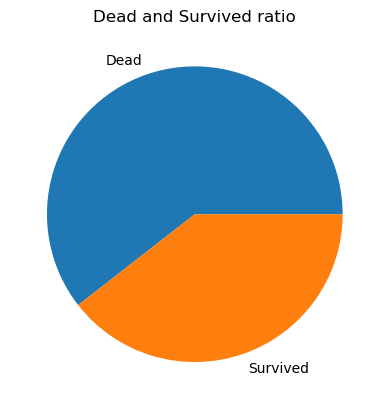

In [5]:
df_train["Survived"].value_counts().plot(kind='pie', title="Dead and Survived ratio", ylabel='', labels=['Dead', 'Survived'
])

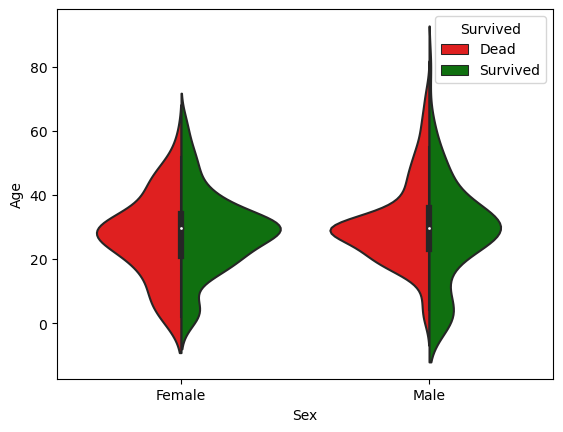

In [6]:
violin = sns.violinplot(x='Sex', y='Age', hue='Survived', data=df_train, split=True, palette={0: 'r', 1: 'g'})
violin.set_xticklabels(['Female', 'Male'])
new_labels = ['Dead', 'Survived']
for t, l in zip(violin.legend_.texts, new_labels): t.set_text(l)

In [7]:
thresh = 0.3
def highlight_above_thresh(s):
    is_above = abs(s) >= thresh 
    return ['font-weight: bold' if v else '' for v in is_above]

corr = df_train.corr(method='pearson')
styled_correlation_matrix = corr.style.apply(highlight_above_thresh, axis=1)
styled_correlation_matrix

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
Pclass,1.000000,0.126986,-0.319927,0.093572,0.048225,-0.543722,0.040708,-0.324024
Sex,0.126986,1.000000,0.089108,-0.079976,-0.242467,-0.183650,-0.124908,-0.550699
Age,-0.319927,0.089108,1.000000,-0.270404,-0.202725,0.071787,0.031524,-0.072729
SibSp,0.093572,-0.079976,-0.270404,1.000000,0.415491,0.136861,-0.049109,-0.031052
Parch,0.048225,-0.242467,-0.202725,0.415491,1.000000,0.151631,-0.072698,0.074699
Fare,-0.543722,-0.183650,0.071787,0.136861,0.151631,1.000000,0.078197,0.264345
Embarked,0.040708,-0.124908,0.031524,-0.049109,-0.072698,0.078197,1.000000,0.099162
Survived,-0.324024,-0.550699,-0.072729,-0.031052,0.074699,0.264345,0.099162,1.000000


In [8]:
cross = pd.crosstab( df_train['Pclass'], df_train['Survived'], normalize="index", margins=True)
cross.rename(columns={0: 'Dead', 1:'Survived'})

Survived,Dead,Survived
Pclass,,
1,0.365169,0.634831
2,0.541096,0.458904
3,0.739691,0.260309
All,0.605337,0.394663


### Feature engineering

In [9]:
def combine_columns(df):
    df["FamSize"] = df["SibSp"] + df["Parch"]
    df.drop(columns=["SibSp", "Parch"], inplace=True)
    return df

In [10]:
def scale_data_train(df):
    age_scaler = preprocessing.MinMaxScaler()
    fare_scaler = preprocessing.MinMaxScaler()
    df["Age"] = age_scaler.fit_transform(df[['Age']])
    df["Fare"] = fare_scaler.fit_transform(df[['Fare']])
    return age_scaler, fare_scaler, df
    
def scale_data_test(age_scaler, fare_scaler, df):
    df["Age"]= age_scaler.transform(df[['Age']])
    df["Fare"]= fare_scaler.transform(df[['Fare']])
    return df

In [11]:
def feature_engineering(df_train, df_test):
    df_train_clean = df_train.copy(deep=True)
    df_test_clean = df_test.copy(deep=True)
    
    df_train_clean = combine_columns(df_train_clean)
    df_test_clean = combine_columns(df_test_clean)
    
    age_scaler, fare_scaler, df_train_clean = scale_data_train(df_train_clean)
    df_test_clean = scale_data_test(age_scaler, fare_scaler, df_test_clean)

    return df_train_clean, df_test_clean

In [12]:
df_train_clean, df_test_clean = feature_engineering(df_train, df_test)
x_train = df_train_clean.drop(['Survived'], axis=1)
y_train = df_train_clean['Survived']

### Training

In [13]:
param_grid_knn = {
    'n_neighbors': np.arange(1, 35),
    'metric': ['minkowski', 'euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier() 
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1', verbose=0)
grid_search_knn.fit(x_train, y_train);

In [14]:
param_grid_dtc = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'criterion': ['gini', 'entropy']
}
dtc = DecisionTreeClassifier() 
grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5, scoring='f1', verbose=0)
grid_search_dtc.fit(x_train, y_train);

In [15]:
def print_top_results(grid_search, n):
    result_df = pd.concat([pd.DataFrame(grid_search.cv_results_["params"]),pd.DataFrame(grid_search.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
    display(result_df.sort_values('Accuracy',ascending = False).head(n))
print_top_results(grid_search_knn, 10)
print_top_results(grid_search_dtc, 10)

,metric,n_neighbors,weights,Accuracy
140,manhattan,3,uniform,0.734047
184,manhattan,25,uniform,0.728992
36,minkowski,19,uniform,0.727403
104,euclidean,19,uniform,0.727403
4,minkowski,3,uniform,0.725986
72,euclidean,3,uniform,0.725986
164,manhattan,15,uniform,0.724970
172,manhattan,19,uniform,0.724721
156,manhattan,11,uniform,0.724561
180,manhattan,23,uniform,0.724415


,criterion,max_depth,min_samples_leaf,min_samples_split,Accuracy
72,entropy,NaN,8,2,0.738359
115,entropy,10.0,8,15,0.738359
114,entropy,10.0,8,10,0.738359
112,entropy,10.0,8,2,0.738359
75,entropy,NaN,8,15,0.738359
74,entropy,NaN,8,10,0.738359
113,entropy,10.0,8,5,0.737287
73,entropy,NaN,8,5,0.737287
80,entropy,5.0,1,2,0.736641
62,entropy,NaN,1,10,0.736243


## Part 3 - Training flow
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 2)

In [16]:
best_params = grid_search_dtc.best_params_
best_model = DecisionTreeClassifier(**best_params)

print(f"best_model={best_model}")

best_model.fit(x_train, y_train);

best_model=DecisionTreeClassifier(criterion='entropy', min_samples_leaf=8)


## Part 4 - Apply on test and show model performance estimation

In [17]:
x_test = df_test_clean.drop(['Survived'], axis=1)
y_test = df_test_clean['Survived']

pred = best_model.predict(x_test)
acc = accuracy_score(y_test, pred, normalize=True)
print(f'Accuracy {acc}')

df_compare = pd.DataFrame({'prediction':pred, 'true value': y_test})
display(df_compare.head(20))

Accuracy 0.8491620111731844


,prediction,true value
0,0,0
1,0,0
2,0,0
3,1,0
4,1,1
5,0,1
6,0,0
7,0,0
8,1,1
9,0,0
